# Hashtags

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

#### Notes

To pull hashtags from captions was simple matter of split each caption by space and selecting strings with '#' at index 0.

To add on hashtags from first comment:

In [2]:
df = pd.read_csv('media_objects1232019.csv', parse_dates = ['timestamp'])
df = df[1:]
df.drop(['media_object_id', 'media_url'], axis = 1, inplace = True)
#Recast some columns as float to allow for aggregating later
cols_to_cast = ['engagement', 'impressions', 'reach', 'saved']
df[cols_to_cast] = df[cols_to_cast].astype(float)

In [4]:
def get_ht(line):
    return [word[1:] for word in line.split() if word[0] == '#']

#Get hashtags from the caption column
fr_cap = [get_ht(line) for line in df['caption'].astype(str).values]
#Get hashtags from the first comment in the comments column
fr_com = [get_ht(ast.literal_eval(line)['data'][0]['text'])\
                              if type(line) == str else [] for line in df['comments'].values ]
#Extend each list in the 'from captions' list by the values in the 'from comments' list
[fr_cap[i].extend(fr_com_i) for i, fr_com_i in enumerate(fr_com)]

#Add this as a column to the df
df['hashtags'] = fr_cap

In [5]:
#Get an expanded df with individual hashtags
exploded = df.drop(['caption', 'comments', 'media_type'], axis = 1).fillna(0).explode('hashtags')
exploded.reset_index(inplace = True)

In [70]:
#94 hashtags end in a period, btw
#len([value for value in hashtags.index[:-1] if value[-1] == '.'])

In [6]:
num_columns = ['comments_count', 'like_count','engagement','impressions', 'reach', 'saved', 'video_views', 'hashtags']
#Group by hashtags to sum up numerical columns
hashtag_df = exploded[num_columns].groupby(['hashtags']).sum()
#Engineer a column that lists the timestamps for each hashtag
#Not needed?
#hashtag_df['timestamps'] = exploded.groupby(['hashtags'])['timestamp'].agg(lambda col: ', '.join(col))
#Engineer a 'frequency' (aka value count) column value for each hashtag
hashtag_df['frequency'] = [exploded['hashtags'].value_counts()[tag] for tag in hashtag_df.index]

#One of these takes a long time. Don't know why

In [7]:
hashtag_df.head()

,comments_count,like_count,engagement,impressions,reach,saved,video_views,frequency
hashtags,,,,,,,,
,0.0,9.0,0.0,0.0,0.0,0.0,0.0,1
1.,7.0,81.0,0.0,0.0,0.0,0.0,0.0,2
1875,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1
2018,0.0,62.0,63.0,858.0,730.0,1.0,0.0,1
3,1.0,20.0,0.0,0.0,0.0,0.0,0.0,1


In [8]:
#Different kinds of sorting
#hashtag_df.sort_values(by = ['like_count'], ascending = False)

In [106]:
#Write dataframe to a csv file
hashtag_df.to_csv('hashtags.csv')

## Working on getting time periods

In [76]:
exploded['timestamp'].resample('D')

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [36]:
exploded.head()

,index,timestamp,comments_count,like_count,engagement,impressions,reach,saved,video_views,hashtags,week,frequency
0,1,2014-11-10 22:47:02+00:00,1.0,8.0,0.0,0.0,0.0,0.0,0.0,cheese,452014,45
1,1,2014-11-10 22:47:02+00:00,1.0,8.0,0.0,0.0,0.0,0.0,0.0,cheesegrotto,452014,29
2,1,2014-11-10 22:47:02+00:00,1.0,8.0,0.0,0.0,0.0,0.0,0.0,elegance,452014,1
3,2,2014-11-10 22:52:51+00:00,0.0,6.0,0.0,0.0,0.0,0.0,0.0,cheesesafe,452014,13
4,2,2014-11-10 22:52:51+00:00,0.0,6.0,0.0,0.0,0.0,0.0,0.0,cheese,452014,45


In [46]:
exploded['week'] = exploded['timestamp'].dt.strftime('%d-%m-%Y')

In [35]:
exploded['frequency'] = [exploded['hashtags'].value_counts()[tag] if type(tag) == str else 0 for tag in exploded['hashtags'].values]

In [47]:
ht_ts = exploded.sort_values(by = ['frequency'], ascending = False)[['week', 'hashtags', 'frequency']]

In [48]:
ht_ts

,week,hashtags,frequency
1628,07-01-2016,cheeselove,142
1664,11-01-2016,cheeselove,142
2902,05-10-2017,cheeselove,142
1678,13-01-2016,cheeselove,142
1681,14-01-2016,cheeselove,142
...,...,...,...
1583,28-12-2015,NaN,0
2360,30-09-2016,NaN,0
2362,03-10-2016,NaN,0
4082,02-07-2019,NaN,0


In [53]:
ht_ts['hashtags'].value_counts().index[:10]

Index(['cheeselove', 'cheeseforlife', 'linkinbio', 'fravorites', 'f52grams',
       'thatcheeseplate', 'creativityfound', 'feedfeed', 'eeeeeats',
       'cheesemaking'],
      dtype='object')

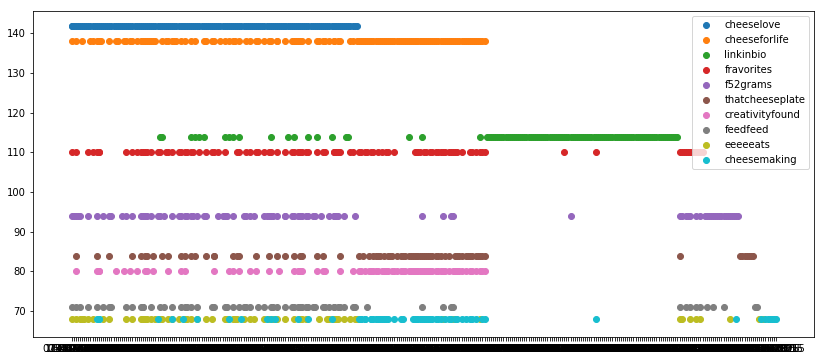

In [54]:
fig = plt.figure(figsize = (14,6))
for tag in ht_ts['hashtags'].value_counts().index[:10]:
    plt.scatter(ht_ts[ht_ts['hashtags'] == tag]['week'], ht_ts[ht_ts['hashtags'] == tag]['frequency'], label = tag)
plt.legend()